# Disco GAN for Gender Exchange
- [github and paper](https://github.com/SKTBrain/DiscoGAN)
- [celebA dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)
    - [images](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg)
    - [attributes](https://drive.google.com/drive/folders/0B7EVK8r0v71pOC0wOVZlQnFfaGs)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from PIL import Image
import torch
from torch.autograd import Variable
from torch import nn, optim
from torch.utils import data
from torchvision import transforms
from torchvision import utils
from torch.nn import functional as F
from os import path

import pandas as pd
from itertools import chain
import random

## data and preprocessing

In [3]:
## Better to implemente as image pairs

class CelebMaleFemale(data.Dataset):
    def __init__(self, image_folder, attr_list, transform=None):
        self.image_folder = image_folder
        self.attributes = self.parse_attributes(attr_list)
        self.transform = transform
        self.male_images = self.attributes[self.attributes.Male=="1"].image_path
        self.female_images = self.attributes[self.attributes.Male=="-1"].image_path
    def __len__(self):
        return max(len(self.male_images), len(self.female_images))
    def __getitem__(self, i):
        imale = random.randint(0, len(self.male_images)-1)
        male_img = Image.open(path.join(self.image_folder, self.male_images.iloc[imale]))
        ifemale = random.randint(0, len(self.female_images)-1)
        female_img = Image.open(path.join(self.image_folder, self.female_images.iloc[ifemale]))
        if self.transform is not None:
            male_img = self.transform(male_img)
            female_img = self.transform(female_img)
        return (male_img, female_img)
    def parse_attributes(self, attr_list):
        attributes = []
        lines = open(attr_list).readlines()
        columns = ["image_path"] + lines[1].split()
        assert len(columns) == 41
        for line in lines[2:]:
            fields = line.split()
            assert len(fields) == 41
            attributes.append(fields)
        return pd.DataFrame(attributes, columns=columns)

In [4]:
image_folder = "/home/dola/data/celebA/img_align_celeba/"
attr_list = "/home/dola/data/celebA/list_attr_celeba.txt"
transform = transforms.Compose([
#     transforms.Scale(78),
    transforms.Scale(64),
    transforms.CenterCrop([64, 64]),
    transforms.ToTensor()
])
celeb_images = CelebMaleFemale(image_folder, attr_list, transform)
len(celeb_images)

118165

In [5]:
a, b = celeb_images[0]

In [6]:
a.size(), b.size()

(torch.Size([3, 64, 64]), torch.Size([3, 64, 64]))

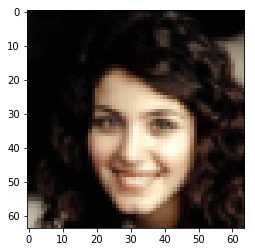

In [7]:
p = transforms.ToPILImage()
plt.imshow(p(b))

## Model

### discriminator

In [8]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.cnn = nn.Sequential(
            # conv1
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), # (64-4+1*2)/2+1=32
            nn.ELU(inplace=True),
            # conv2
            nn.Conv2d(64, 64*2, kernel_size=4, stride=2, padding=1, bias=False), #(32-4+1*2)/2+1=16
            nn.BatchNorm2d(64*2),
            nn.ELU(inplace=True),
            # conv3
            nn.Conv2d(64*2, 64*4, kernel_size=4, stride=2, padding=1, bias=False), #(16-4+2*1)/2+1=8
            nn.BatchNorm2d(64*4),
            nn.ELU(inplace=True),
            # conv4
            nn.Conv2d(64*4, 64*8, kernel_size=4, stride=2, padding=1, bias=False), #(8-4+2*1)/2+1=4
            nn.BatchNorm2d(64*8),
            nn.ELU(inplace=True),
            # conv5
            nn.Conv2d(64*8, 1, kernel_size=4, stride=1, padding=0, bias=False), #(4-4+0)/1+1=1
        )
        self.cnn1 = nn.Sequential(
            # conv1
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), # (64-4+1*2)/2+1=32
            nn.ELU(inplace=True)
        )
        self.cnn2 = nn.Sequential(
            # conv2
            nn.Conv2d(64, 64*2, kernel_size=4, stride=2, padding=1, bias=False), #(32-4+1*2)/2+1=16
            nn.BatchNorm2d(64*2),
            nn.ELU(inplace=True),
        )
        self.cnn3 = nn.Sequential(
            # conv3
            nn.Conv2d(64*2, 64*4, kernel_size=4, stride=2, padding=1, bias=False), #(16-4+2*1)/2+1=8
            nn.BatchNorm2d(64*4),
            nn.ELU(inplace=True),
        )
        self.cnn4 = nn.Sequential(
            # conv4
            nn.Conv2d(64*4, 64*8, kernel_size=4, stride=2, padding=1, bias=False), #(8-4+2*1)/2+1=4
            nn.BatchNorm2d(64*8),
            nn.ELU(inplace=True),
        )
        self.cnn5 = nn.Sequential(
            # conv5
            nn.Conv2d(64*8, 1, kernel_size=4, stride=1, padding=0, bias=False), #(4-4+0)/1+1=1
        )
    def forward(self, x):
        out1 = self.cnn1(x)
        out2 = self.cnn2(out1)
        out3 = self.cnn3(out2)
        out4 = self.cnn4(out3)
        out = self.cnn5(out4)
        prob = F.sigmoid(out)
        return prob, [out2, out3, out4]

In [9]:
d = Discriminator().cuda()
x = Variable(torch.rand([1, 3, 64, 64])).cuda()
prob, feats = d(x)
prob.size()

torch.Size([1, 1, 1, 1])

### generator

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            # (64-4+2)/2+1=32
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ELU(inplace=True),
            # (32-4+2)/2+1=16
            nn.Conv2d(64, 64*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.ELU(inplace=True),
            # (16-4+2)/2+1=8
            nn.Conv2d(64*2, 64*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.ELU(inplace=True),
            # (8-4+2)/2+1=4
            nn.Conv2d(64*4, 64*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*8),
            nn.ELU(inplace=True)
        )
        self.decoder = nn.Sequential(
            # (4-1)*2+4-2=8
            nn.ConvTranspose2d(64*8, 64*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.ELU(inplace=True),
            # (8-1)*2+4-2=16
            nn.ConvTranspose2d(64*4, 64*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.ELU(inplace=True),
            # (16-1)*2+4-2=32
            nn.ConvTranspose2d(64*2, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ELU(inplace=True),
            # (32-1)*2+4-2=64
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False)
        )
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        out = F.sigmoid(out) # normalize to [0,1]
        return out

In [11]:
g = Generator().cuda()
x = Variable(torch.rand([1, 3, 64, 64])).cuda()
g(x).size()

torch.Size([1, 3, 64, 64])

## Train

In [12]:
batch_size = 96

generator_m2f = Generator().cuda()
generator_f2m = Generator().cuda()
discriminator_m = Discriminator().cuda()
discriminator_f = Discriminator().cuda()

In [88]:
preload = True
if preload:
    import pickle
    generator_m2f.load_state_dict(pickle.load(open("../../models/generator_m2f.pkl", "rb")))
    generator_f2m.load_state_dict(pickle.load(open("../../models/generator_f2m.pkl", "rb")))
    discriminator_f.load_state_dict(pickle.load(open("../../models/discriminator_f.pkl", "rb")))
    discriminator_m.load_state_dict(pickle.load(open("../../models/discriminator_m.pkl", "rb")))

In [13]:



reconstruction_objective = nn.MSELoss()
gan_objective = nn.BCELoss()

# feat objective helps converge
feat_objective = nn.HingeEmbeddingLoss() 
def get_feat_loss(real_feats, fake_feats):
    loss = 0
    for real_feat, fake_feat in zip(real_feats, fake_feats):
        l2 = torch.pow(real_feat.mean(0)-fake_feat.mean(0), 2)
        loss += feat_objective(l2, Variable(torch.ones(l2.size())).cuda())
    return loss

## we have to train generators together (the same with discrinators) because
## the loss depend on both encoders and decoders
generator_params = chain(generator_m2f.parameters(), generator_f2m.parameters())
discriminator_params = chain(discriminator_m.parameters(), discriminator_f.parameters())
gen_optimizer = optim.Adam(generator_params, lr=5e-4)
dis_optimizer = optim.Adam(discriminator_params, lr=5e-4)


image_pairs = data.DataLoader(celeb_images, batch_size=batch_size, 
                              shuffle=False, num_workers=4)

In [75]:
n_epochs = 10

iters = 0
for epoch in range(n_epochs):
    for b, (male_images, female_images) in enumerate(image_pairs):
        iters += 1
        
        ## input variables        
        m = Variable(male_images).cuda()
        f = Variable(female_images).cuda()
        
        ## generator variables
        m2f = generator_m2f(m)
        f2m = generator_f2m(f)
        
        m2f2m = generator_f2m(m2f)
        f2m2f = generator_m2f(f2m)
        
        ## discriminator variables
        m_is_m, m_feat = discriminator_m(m)
        f2m_is_m, f2m_feat = discriminator_m(f2m)
        
        f_is_f, f_feat = discriminator_f(f)
        m2f_is_f, m2f_feat = discriminator_f(m2f)
        
        n = m.size(0)
        label1 = Variable(torch.ones(n, 1)).cuda()
        label0 = Variable(torch.zeros(n, 0)).cuda()
        
        ## generator reconstruction loss
        gen_m_recon_loss = reconstruction_objective(m2f2m, m)
        gen_f_recon_loss = reconstruction_objective(f2m2f, f)
        
        ## generator gan loss
        generator_m_gan_loss = gan_objective(f2m_is_m, label1)
        generator_f_gan_loss = gan_objective(m2f_is_f, label1)
        
        ## generator feat loss
        generator_m_feat_loss = get_feat_loss(m_feat, f2m_feat)
        generator_f_feat_loss = get_feat_loss(f_feat, m2f_feat)
        
        ## generator loss
        rate = 0.01 if iters < 10000 else 0.5
        generator_m_loss = (1-rate)*(generator_m_gan_loss*0.1+generator_m_feat_loss*0.9) + rate*gen_m_recon_loss
        generator_f_loss = (1-rate)*(generator_f_gan_loss*0.1+generator_f_feat_loss*0.9) + rate*gen_f_recon_loss
        
        generator_loss = generator_m_loss + generator_f_loss
        
        ## discriminator gan loss
        discriminator_m_loss = gan_objective(m_is_m, label1)*.5 + gan_objective(f2m_is_m, label0)*.5
        discriminator_f_loss = gan_objective(f_is_f, label1)*.5 + gan_objective(m2f_is_f, label0)*.5
        
        discriminator_loss = discriminator_m_loss + discriminator_f_loss
        
        ## update
        if b % 3 == 0:
            discriminator_m.zero_grad()
            discriminator_f.zero_grad()
            discriminator_loss.backward()
            dis_optimizer.step()
        else:
            generator_m2f.zero_grad()
            generator_f2m.zero_grad()
            generator_loss.backward()
            gen_optimizer.step()
        
        ## report
        if b % 200 == 0:
            print(epoch, b, generator_loss.data[0], discriminator_loss.data[0])
            print("==>g_m_loss=%.2f, g_f_loss=%.2f, d_m_loss=%.2f, d_f_loss=%.2f" % (generator_m_loss.data[0],
                                                                                    generator_f_loss.data[0],
                                                                                    discriminator_m_loss.data[0],
                                                                                    discriminator_f_loss.data[0]))

0 0 0.18149331212043762 1.3798468112945557
==>g_m_loss=0.09, g_f_loss=0.09, d_m_loss=0.70, d_f_loss=0.68
0 200 0.15758636593818665 1.452951192855835
==>g_m_loss=0.08, g_f_loss=0.07, d_m_loss=0.73, d_f_loss=0.72
0 400 0.14069287478923798 1.439945101737976
==>g_m_loss=0.06, g_f_loss=0.08, d_m_loss=0.72, d_f_loss=0.72
0 600 0.16539302468299866 1.4271998405456543
==>g_m_loss=0.09, g_f_loss=0.08, d_m_loss=0.71, d_f_loss=0.72
0 800 0.14717313647270203 1.4035035371780396
==>g_m_loss=0.08, g_f_loss=0.07, d_m_loss=0.69, d_f_loss=0.71
0 1000 0.1495305597782135 1.3840899467468262
==>g_m_loss=0.07, g_f_loss=0.08, d_m_loss=0.69, d_f_loss=0.70
0 1200 0.14708028733730316 1.4047060012817383
==>g_m_loss=0.07, g_f_loss=0.07, d_m_loss=0.71, d_f_loss=0.69
1 0 0.15273164212703705 1.3894107341766357
==>g_m_loss=0.08, g_f_loss=0.07, d_m_loss=0.69, d_f_loss=0.70
1 200 0.14753684401512146 1.414757251739502
==>g_m_loss=0.07, g_f_loss=0.07, d_m_loss=0.71, d_f_loss=0.70
1 400 0.1490173488855362 1.4210717678070068

In [96]:
man, woman = celeb_images[0]
man2woman = generator_m2f(Variable(man).cuda()[None, ...])
woman2man = generator_f2m(Variable(woman).cuda()[None, ...])

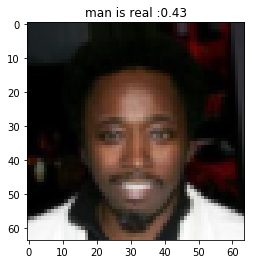

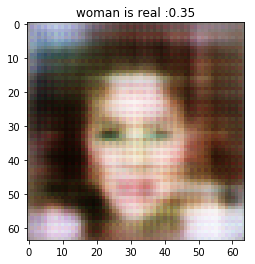

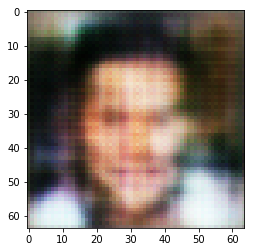

In [90]:
plt.imshow(p(man))
plt.title("man is real :%.2f"%discriminator_m(Variable(man).cuda()[None, ...])[0].data.squeeze()[0])
plt.figure()
plt.imshow(p(man2woman.cpu().data.squeeze()))
plt.title("woman is real :%.2f"%discriminator_m(man2woman)[0].data.squeeze()[0])
plt.figure()
plt.imshow(p(generator_f2m(man2woman).data.squeeze().cpu()))

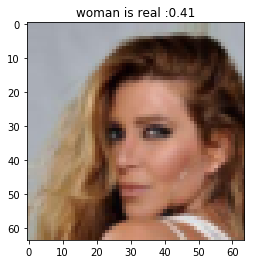

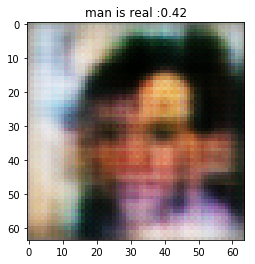

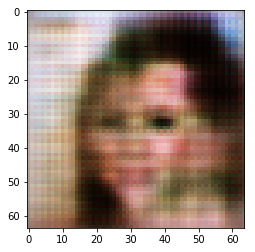

In [97]:
plt.imshow(p(woman))
plt.title("woman is real :%.2f"%discriminator_m(Variable(woman).cuda()[None, ...])[0].data.squeeze()[0])
plt.figure()
plt.imshow(p(woman2man.cpu().data.squeeze()))
plt.title("man is real :%.2f"%discriminator_m(woman2man)[0].data.squeeze()[0])
plt.figure()
plt.imshow(p(generator_m2f(woman2man).data.squeeze().cpu()))

In [18]:
import pickle
pickle.dump(generator_m2f.state_dict(), open("../../models/generator_m2f.pkl", "wb"))
pickle.dump(generator_f2m.state_dict(), open("../../models/generator_f2m.pkl", "wb"))
pickle.dump(discriminator_f.state_dict(), open("../../models/discriminator_f.pkl", "wb"))
pickle.dump(discriminator_m.state_dict(), open("../../models/discriminator_m.pkl", "wb"))

In [19]:
!ls -lh ../../models

total 190M
-rw-rw-r-- 1 dola dola 48M Jul 29 21:47 discriminator_f.pkl
-rw-rw-r-- 1 dola dola 48M Jul 29 21:47 discriminator_m.pkl
-rw-rw-r-- 1 dola dola 48M Jul 29 21:46 generator_f2m.pkl
-rw-rw-r-- 1 dola dola 48M Jul 29 21:45 generator_m2f.pkl
